In [1]:
import pickle
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(1234)

In [3]:
df_embeds = pd.read_csv('../../classical_ML/data/Orthrus_data/orthrus_features_clean.tsv.gz', sep='\t')
df_embeds.dropna(subset = ['embed0'], inplace=True)
embed_cols = [f'embed{i}' for i in range(512)]
df_embeds = df_embeds[['Transcript ID']+embed_cols]
df_embeds.rename(columns={"Transcript ID": "Transcript_ID"}, inplace=True)
df_embeds

Transcript_ID    embed0    embed1    embed2    embed3    embed4  \
0      ENST00000263100  0.122282  0.177534 -0.048803 -0.165734 -0.034072   
1      ENST00000373997  0.342975  0.134082  0.039255 -0.224912 -0.052249   
2      ENST00000318602  0.331549  0.211808 -0.040499 -0.144805 -0.050687   
3      ENST00000299698  0.337860  0.260349 -0.019156 -0.144985 -0.045211   
4      ENST00000442999  0.120457  0.181139  0.107973 -0.104078 -0.039713   
...                ...       ...       ...       ...       ...       ...   
18479  ENST00000371528  0.189914  0.113874  0.061029 -0.105412 -0.031373   
18480  ENST00000294353  0.223297  0.086196  0.052600 -0.128977 -0.027397   
18481  ENST00000322764  0.254627  0.138448  0.156764 -0.182271  0.062424   
18482  ENST00000381638  0.442461  0.263657 -0.102592 -0.080843  0.024760   
18483  ENST00000370801  0.265919  0.088128  0.036297 -0.152144 -0.144289   

         embed5    embed6    embed7    embed8  ...  embed502  embed503  \
0     -0.264644 -0.057117 -0.227631 -0.529456  ... -0.041493  0.312705   
1     -0.148360 -0.062987 -0.092132 -0.442369  ... -0.327766  0.412198   
2     -0.184935  0.127531 -0.119810 -0.621050  ... -0.248826  0.385974   
3     -0.194701  0.104279 -0.138256 -0.562558  ... -0.233801  0.381406   
4     -0.133477  0.049908 -0.193681 -0.174398  ... -0.172032  0.451827   
...         ...       ...       ...       ...  ...       ...       ...   
18479 -0.201013 -0.110164 -0.084314 -0.437392  ... -0.185700  0.380479   
18480 -0.177775 -0.117537 -0.079050 -0.434602  ... -0.188737  0.404469   
18481 -0.127684 -0.138878 -0.132653 -0.478736  ... -0.293639  0.455482   
18482 -0.054935  0.484756 -0.382065 -0.816725  ... -0.153948  0.554390   
18483 -0.058734 -0.107623 -0.016273 -0.391301  ... -0.280676  0.401803   

       embed504  embed505  embed506  embed507  embed508  embed509  embed510  \
0      0.183835  0.282550  0.097991  0.247955 -0.156811  0.038840 -0.064718   
1      0.237658  0.315500  0.118175  0.254118 -0.152559  0.185892 -0.129714   
2      0.509238  0.150244  0.153647  0.098654 -0.023546  0.113986 -0.099528   
3      0.526234  0.110568  0.128577  0.106606 -0.047536  0.093703 -0.121776   
4      0.141332  0.319514  0.230903  0.197436 -0.121235  0.083669 -0.072020   
...         ...       ...       ...       ...       ...       ...       ...   
18479  0.177239  0.300294  0.138531  0.178986 -0.119901  0.136907 -0.033310   
18480  0.187927  0.321878  0.120758  0.228710 -0.140578  0.149540  0.003069   
18481  0.232366  0.347795  0.366158  0.279273  0.026741  0.107467  0.051708   
18482  1.176475 -0.155350  0.156531  0.152959  0.140080 -0.022837 -0.029495   
18483  0.279259  0.340833  0.243228  0.220887 -0.012395  0.156450  0.042347   

       embed511  
0     -0.006802  
1      0.020999  
2      0.030393  
3     -0.045927  
4     -0.016692  
...         ...  
18479 -0.126740  
18480 -0.073322  
18481 -0.081295  
18482 -0.261842  
18483  0.000610  

[17774 rows x 513 columns]

In [4]:
all_stop_gains = pd.read_csv('../data/all_codingOnly_sorted_annotated_complete.tsv.gz', sep='\t')
all_stop_gains = all_stop_gains.merge(df_embeds, how='left')
all_stop_gains

CHROM       POS REF ALT SYMBOL             Gene    Transcript_ID  \
0           1     65568   A   T  OR4F5  ENSG00000186092  ENST00000641515   
1           1     69046   G   T  OR4F5  ENSG00000186092  ENST00000641515   
2           1     69059   G   A  OR4F5  ENSG00000186092  ENST00000641515   
3           1     69060   G   A  OR4F5  ENSG00000186092  ENST00000641515   
4           1     69064   G   T  OR4F5  ENSG00000186092  ENST00000641515   
...       ...       ...  ..  ..    ...              ...              ...   
2921288     Y  25041852   A   T  BPY2C  ENSG00000185894  ENST00000382287   
2921289     Y  25041854   G   T  BPY2C  ENSG00000185894  ENST00000382287   
2921290     Y  25041857   A   C  BPY2C  ENSG00000185894  ENST00000382287   
2921291     Y  25041857   A   T  BPY2C  ENSG00000185894  ENST00000382287   
2921292     Y  25041874   C   A  BPY2C  ENSG00000185894  ENST00000382287   

                    ENSP EXON                       HGVSc  ...  embed502  \
0        ENSP00000493376  2/3    ENST00000641515.2:c.4A>T  ... -0.195477   
1        ENSP00000493376  3/3   ENST00000641515.2:c.19G>T  ... -0.195477   
2        ENSP00000493376  3/3   ENST00000641515.2:c.32G>A  ... -0.195477   
3        ENSP00000493376  3/3   ENST00000641515.2:c.33G>A  ... -0.195477   
4        ENSP00000493376  3/3   ENST00000641515.2:c.37G>T  ... -0.195477   
...                  ...  ...                         ...  ...       ...   
2921288  ENSP00000371724  5/9  ENST00000382287.5:c.113T>A  ... -0.265535   
2921289  ENSP00000371724  5/9  ENST00000382287.5:c.111C>A  ... -0.265535   
2921290  ENSP00000371724  5/9  ENST00000382287.5:c.108T>G  ... -0.265535   
2921291  ENSP00000371724  5/9  ENST00000382287.5:c.108T>A  ... -0.265535   
2921292  ENSP00000371724  5/9   ENST00000382287.5:c.91G>T  ... -0.265535   

         embed503  embed504  embed505  embed506  embed507  embed508  embed509  \
0        0.321246  0.295824  0.299825  0.110519  0.189773 -0.193410  0.232638   
1        0.321246  0.295824  0.299825  0.110519  0.189773 -0.193410  0.232638   
2        0.321246  0.295824  0.299825  0.110519  0.189773 -0.193410  0.232638   
3        0.321246  0.295824  0.299825  0.110519  0.189773 -0.193410  0.232638   
4        0.321246  0.295824  0.299825  0.110519  0.189773 -0.193410  0.232638   
...           ...       ...       ...       ...       ...       ...       ...   
2921288  0.355439  0.201580  0.372579  0.233566  0.158803 -0.076542  0.166773   
2921289  0.355439  0.201580  0.372579  0.233566  0.158803 -0.076542  0.166773   
2921290  0.355439  0.201580  0.372579  0.233566  0.158803 -0.076542  0.166773   
2921291  0.355439  0.201580  0.372579  0.233566  0.158803 -0.076542  0.166773   
2921292  0.355439  0.201580  0.372579  0.233566  0.158803 -0.076542  0.166773   

         embed510  embed511  
0        0.047435 -0.111034  
1        0.047435 -0.111034  
2        0.047435 -0.111034  
3        0.047435 -0.111034  
4        0.047435 -0.111034  
...           ...       ...  
2921288  0.081839  0.078719  
2921289  0.081839  0.078719  
2921290  0.081839  0.078719  
2921291  0.081839  0.078719  
2921292  0.081839  0.078719  

[2921293 rows x 581 columns]

In [700]:
print(f'number of simulated variants is {len(all_stop_gains)} and number of unique transcripts is {len(all_stop_gains.Transcript_ID.unique())}')

number of simulated variants is 2921293 and number of unique transcripts is 18372


In [5]:
def apply_baseline_rules(df, exon_len_threshold=407, penultimate_threshold=55, start_threshold=100):

    # long exon rule
    df['long_exon'] = 0
    df.loc[df['current_exon_len'] > exon_len_threshold, 'long_exon'] = 1

    # penultimate exon rule
    df['penultimate_flag'] = 0
    df.loc[
        (df['DIST_FROM_LAST_EXON'] < penultimate_threshold) &
        (df['DIST_FROM_LAST_EXON'] >= 0), 
        'penultimate_flag'
    ] = 1

    # close to start rule
    df['close_to_start'] = 0
    df.loc[df['CDS_position'] < start_threshold, 'close_to_start'] = 1

    return df


# last exon rule
all_stop_gains['last_exon'] = 0
all_stop_gains.loc[all_stop_gains['current_exon_number']==all_stop_gains['total_exon_numbers'], 'last_exon'] = 1

all_stop_gains = apply_baseline_rules(all_stop_gains, exon_len_threshold=355, penultimate_threshold=49, start_threshold=120)
all_stop_gains

CHROM       POS REF ALT SYMBOL             Gene    Transcript_ID  \
0           1     65568   A   T  OR4F5  ENSG00000186092  ENST00000641515   
1           1     69046   G   T  OR4F5  ENSG00000186092  ENST00000641515   
2           1     69059   G   A  OR4F5  ENSG00000186092  ENST00000641515   
3           1     69060   G   A  OR4F5  ENSG00000186092  ENST00000641515   
4           1     69064   G   T  OR4F5  ENSG00000186092  ENST00000641515   
...       ...       ...  ..  ..    ...              ...              ...   
2921288     Y  25041852   A   T  BPY2C  ENSG00000185894  ENST00000382287   
2921289     Y  25041854   G   T  BPY2C  ENSG00000185894  ENST00000382287   
2921290     Y  25041857   A   C  BPY2C  ENSG00000185894  ENST00000382287   
2921291     Y  25041857   A   T  BPY2C  ENSG00000185894  ENST00000382287   
2921292     Y  25041874   C   A  BPY2C  ENSG00000185894  ENST00000382287   

                    ENSP EXON                       HGVSc  ...  embed506  \
0        ENSP00000493376  2/3    ENST00000641515.2:c.4A>T  ...  0.110519   
1        ENSP00000493376  3/3   ENST00000641515.2:c.19G>T  ...  0.110519   
2        ENSP00000493376  3/3   ENST00000641515.2:c.32G>A  ...  0.110519   
3        ENSP00000493376  3/3   ENST00000641515.2:c.33G>A  ...  0.110519   
4        ENSP00000493376  3/3   ENST00000641515.2:c.37G>T  ...  0.110519   
...                  ...  ...                         ...  ...       ...   
2921288  ENSP00000371724  5/9  ENST00000382287.5:c.113T>A  ...  0.233566   
2921289  ENSP00000371724  5/9  ENST00000382287.5:c.111C>A  ...  0.233566   
2921290  ENSP00000371724  5/9  ENST00000382287.5:c.108T>G  ...  0.233566   
2921291  ENSP00000371724  5/9  ENST00000382287.5:c.108T>A  ...  0.233566   
2921292  ENSP00000371724  5/9   ENST00000382287.5:c.91G>T  ...  0.233566   

         embed507  embed508  embed509  embed510  embed511 last_exon  \
0        0.189773 -0.193410  0.232638  0.047435 -0.111034         0   
1        0.189773 -0.193410  0.232638  0.047435 -0.111034         1   
2        0.189773 -0.193410  0.232638  0.047435 -0.111034         1   
3        0.189773 -0.193410  0.232638  0.047435 -0.111034         1   
4        0.189773 -0.193410  0.232638  0.047435 -0.111034         1   
...           ...       ...       ...       ...       ...       ...   
2921288  0.158803 -0.076542  0.166773  0.081839  0.078719         0   
2921289  0.158803 -0.076542  0.166773  0.081839  0.078719         0   
2921290  0.158803 -0.076542  0.166773  0.081839  0.078719         0   
2921291  0.158803 -0.076542  0.166773  0.081839  0.078719         0   
2921292  0.158803 -0.076542  0.166773  0.081839  0.078719         0   

         long_exon penultimate_flag  close_to_start  
0                0                1               1  
1                1                0               1  
2                1                0               1  
3                1                0               1  
4                1                0               1  
...            ...              ...             ...  
2921288          0                0               1  
2921289          0                0               1  
2921290          0                0               1  
2921291          0                0               1  
2921292          0                0               1  

[2921293 rows x 585 columns]

In [6]:
last_exon_genes = all_stop_gains[all_stop_gains['last_exon']==1]['SYMBOL'].unique()
start_genes = all_stop_gains[all_stop_gains['close_to_start']==1]['SYMBOL'].unique()
intersect_genes = [x for x in last_exon_genes if x in start_genes]
print(intersect_genes)

['OR4F5', 'OR4F29', 'OR4F16', 'NOC2L', 'KLHL17', 'ISG15', 'RNF223', 'TTLL10', 'SDF4', 'B3GALT6', 'C1QTNF12', 'PUSL1', 'CPTP', 'TAS1R3', 'MRPL20', 'TMEM88B', 'ATAD3C', 'FNDC10', 'FAAP20', 'SKI', 'MORN1', 'PANK4', 'HES5', 'TNFRSF14', 'ACTRT2', 'ARHGEF16', 'WRAP73', 'CCDC27', 'LRRC47', 'NPHP4', 'RNF207', 'ICMT', 'HES3', 'GPR153', 'HES2', 'NOL9', 'ZBTB48', 'PHF13', 'TNFRSF9', 'SLC2A7', 'SLC2A5', 'GPR157', 'SLC25A33', 'NMNAT1', 'RBP7', 'PGD', 'PEX14', 'CASZ1', 'EXOSC10', 'MTOR', 'ANGPTL7', 'FBXO2', 'DRAXIN', 'PLOD1', 'MIIP', 'TNFRSF1B', 'AADACL4', 'AADACL3', 'PRAMEF12', 'PRAMEF1', 'PRAMEF11', 'HNRNPCL1', 'PRAMEF2', 'PRAMEF4', 'PRAMEF10', 'PRAMEF6', 'PRAMEF27', 'PRAMEF25', 'HNRNPCL2', 'PRAMEF26', 'HNRNPCL4', 'PRAMEF9', 'PRAMEF18', 'PRAMEF5', 'PRAMEF33', 'PRAMEF15', 'PRAMEF14', 'PRAMEF19', 'PRAMEF17', 'PRAMEF20', 'LRRC38', 'KAZN', 'CTRC', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'TMEM82', 'SPEN', 'SRARP', 'FAM131C', 'EPHA2', 'ARHGEF19', 'CPLANE2', 'FBXO42', 'NBPF1', 'CROCC', 'PADI2', 'PADI1', 'PADI3',

In [1265]:
selected_gene = np.random.choice(intersect_genes)
#selected_gene = 'TLR7'
print(f'selected gene is {selected_gene}')
all_stop_gains2 = all_stop_gains[all_stop_gains['SYMBOL']==selected_gene]
all_stop_gains2

selected gene is CPA2


CHROM        POS REF ALT SYMBOL             Gene    Transcript_ID  \
1253576     7  130266895   T   A   CPA2  ENSG00000158516  ENST00000222481   
1253577     7  130266932   C   A   CPA2  ENSG00000158516  ENST00000222481   
1253578     7  130266932   C   G   CPA2  ENSG00000158516  ENST00000222481   
1253579     7  130266935   T   A   CPA2  ENSG00000158516  ENST00000222481   
1253580     7  130266939   G   T   CPA2  ENSG00000158516  ENST00000222481   
...       ...        ...  ..  ..    ...              ...              ...   
1253715     7  130289709   A   T   CPA2  ENSG00000158516  ENST00000222481   
1253716     7  130289721   G   T   CPA2  ENSG00000158516  ENST00000222481   
1253717     7  130289730   C   T   CPA2  ENSG00000158516  ENST00000222481   
1253718     7  130289744   T   A   CPA2  ENSG00000158516  ENST00000222481   
1253719     7  130289744   T   G   CPA2  ENSG00000158516  ENST00000222481   

                    ENSP   EXON                        HGVSc  ...  embed506  \
1253576  ENSP00000222481   1/11    ENST00000222481.9:c.14T>A  ...  0.250634   
1253577  ENSP00000222481   1/11    ENST00000222481.9:c.51C>A  ...  0.250634   
1253578  ENSP00000222481   1/11    ENST00000222481.9:c.51C>G  ...  0.250634   
1253579  ENSP00000222481   1/11    ENST00000222481.9:c.54T>A  ...  0.250634   
1253580  ENSP00000222481   1/11    ENST00000222481.9:c.58G>T  ...  0.250634   
...                  ...    ...                          ...  ...       ...   
1253715  ENSP00000222481  11/11  ENST00000222481.9:c.1222A>T  ...  0.250634   
1253716  ENSP00000222481  11/11  ENST00000222481.9:c.1234G>T  ...  0.250634   
1253717  ENSP00000222481  11/11  ENST00000222481.9:c.1243C>T  ...  0.250634   
1253718  ENSP00000222481  11/11  ENST00000222481.9:c.1257T>A  ...  0.250634   
1253719  ENSP00000222481  11/11  ENST00000222481.9:c.1257T>G  ...  0.250634   

         embed507  embed508  embed509  embed510  embed511 last_exon  \
1253576  0.194769 -0.103325  0.146743 -0.112464 -0.018372         0   
1253577  0.194769 -0.103325  0.146743 -0.112464 -0.018372         0   
1253578  0.194769 -0.103325  0.146743 -0.112464 -0.018372         0   
1253579  0.194769 -0.103325  0.146743 -0.112464 -0.018372         0   
1253580  0.194769 -0.103325  0.146743 -0.112464 -0.018372         0   
...           ...       ...       ...       ...       ...       ...   
1253715  0.194769 -0.103325  0.146743 -0.112464 -0.018372         1   
1253716  0.194769 -0.103325  0.146743 -0.112464 -0.018372         1   
1253717  0.194769 -0.103325  0.146743 -0.112464 -0.018372         1   
1253718  0.194769 -0.103325  0.146743 -0.112464 -0.018372         1   
1253719  0.194769 -0.103325  0.146743 -0.112464 -0.018372         1   

         long_exon penultimate_flag  close_to_start  
1253576          0                0               1  
1253577          0                0               1  
1253578          0                0               1  
1253579          0                0               1  
1253580          0                0               1  
...            ...              ...             ...  
1253715          0                0               0  
1253716          0                0               0  
1253717          0                0               0  
1253718          0                0               0  
1253719          0                0               0  

[144 rows x 585 columns]

In [1266]:
prot_feat_df = pd.read_csv('../data/protein_AA_features.tsv.gz', sep='\t')
prot_feat_df.rename(columns={'MANE-Select':'Transcript_ID'}, inplace=True)
prot_feat_df.drop(columns=['Unnamed: 0', 'Entry'], axis=1, inplace=True)
prot_feat_df

Transcript_ID actual_or_pred_ACT_SITE  \
0      ENST00000436697                    pred   
1      ENST00000709217                    pred   
2      ENST00000374922                    pred   
3      ENST00000637218                  actual   
4      ENST00000469902                    pred   
...                ...                     ...   
18412  ENST00000295896                    pred   
18413  ENST00000295898                    pred   
18414  ENST00000306862                    pred   
18415  ENST00000450660                    pred   
18416  ENST00000420162                    pred   

                              annotation_actual_ACT_SITE  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3      0000000000000000000000000000000000000000000000...   
4                                                    NaN   
...                                                  ...   
18412                                                NaN   
18413                                                NaN   
18414                                                NaN   
18415                                                NaN   
18416                                                NaN   

                                annotation_pred_ACT_SITE  \
0      0000000000000000000000000000000000000000000000...   
1      0000000000000000000000000000000000000000000000...   
2      0000000000000000000000000000000000000000000000...   
3                                                    NaN   
4      0000000000000000000000000000000000000000000000...   
...                                                  ...   
18412  0000000000000000000000000000000000000000000000...   
18413  0000000000000000000000000000000000000000000000...   
18414  0000000000000000000000000000000000000000000000...   
18415  0000000000000000000000000000000000000000000000...   
18416  0000000000000000000000000000000000000000000000...   

      actual_or_pred_BINDING  \
0                       pred   
1                       pred   
2                       pred   
3                     actual   
4                       pred   
...                      ...   
18412                   pred   
18413                   pred   
18414                   pred   
18415                   pred   
18416                   pred   

                               annotation_actual_BINDING  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3      0000000000000000000000000000000000000000000000...   
4                                                    NaN   
...                                                  ...   
18412                                                NaN   
18413                                                NaN   
18414                                                NaN   
18415                                                NaN   
18416                                                NaN   

                                 annotation_pred_BINDING  \
0      0000000000000000000000000000000000000000000000...   
1      0000000000000000000000000000000000000000000000...   
2      0000000000000000000000000000000000000000000000...   
3                                                    NaN   
4      0000000000000000000000000000000000000000000000...   
...                                                  ...   
18412  0000000000000000000000000000000000000000000000...   
18413  0000000000000000000000000000000000000000000000...   
18414  0000000000000000000000000000000000000000000000...   
18415  0000000000000000000000000000000000000000000000...   
18416  0000000000000000000000000000000000000000000000...   

      actual_or_pred_COILED annotation_actual_COILED  \
0                      pred                      NaN   
1                      pred

In [1267]:
# Calculate the proportion of lost features upon stop-gain
all_stop_gains2 = all_stop_gains2.merge(prot_feat_df, how='left')

prot_feat_list = ['ACT_SITE', 'BINDING', 'COILED', 'COMPBIAS', 'DISULFID', 'BINDING', 'DOMAIN', 
                 'HELIX', 'MOD_RES', 'MOTIF', 'PROPEP', 'REGION', 'REPEAT', 'SIGNAL', 'STRAND',
                 'TOPO_DOM', 'TRANSIT', 'TRANSMEM', 'TURN', 'ZN_FING']

for prot_feat in prot_feat_list:
    all_stop_gains2[f'prop_lost_{prot_feat}'] = None


for idx, row in all_stop_gains2.iterrows():
    
    for prot_feat_name in prot_feat_list:
        temp_pred_or_actual = row[f'actual_or_pred_{prot_feat_name}']
        
        if not pd.isna(temp_pred_or_actual):
            
            prot_feat_binary = row[f'annotation_{temp_pred_or_actual}_{prot_feat_name}']
            
            if row['Protein_position'] <= len(prot_feat_binary):
                prot_feat_binary_lost = prot_feat_binary[row['Protein_position']:]
                all_stop_gains2.loc[idx, f'prop_lost_{prot_feat_name}'] = prot_feat_binary_lost.count('1') / len(prot_feat_binary)

prot_lost_feat_list = [f'prop_lost_{x}' for x in prot_feat_list]

In [1268]:
all_stop_gains2['LoF_HC'] = (all_stop_gains2['LoF'] == 'HC').astype(int)

In [1269]:
my_features = ['last_exon', 'long_exon', 'penultimate_flag', 'close_to_start', 'hl',
       'mrl', 'cDNA_position', 'PERCENTILE', 'GERP_DIST', 'BP_DIST',
       'utr5_len', 'current_exon_len', 'VEST4_score', 'CADD_phred',
       'phyloP100way_vertebrate', 'dn_ds', 'abundance', 'shet',
       'lof.oe_ci.upper', 'lof.pRec', 'UTR5_GC', 'connectedness',
       'prop_lost_DOMAIN', 'prop_lost_HELIX', 'prop_lost_REGION',
       'prop_lost_TOPO_DOM', 'LoF_HC', 'NearestExonJB_dist', 'TF', 'tau',
       'phyloP17way_primate', 'phyloP470way_mammalian',
       'phastCons100way_vertebrate', 'phastCons17way_primate',
       'phastCons470way_mammalian', 'mis.z_score', 'syn.z_score', 'lof.pNull',
       'exp_var', 'utr3_len', 'total_exons_len', 'fathmm-XF_coding_score',
       'Nucleus', 'Cytosol', 'Cytoplasm', 'Ribosome', 'Membrane',
       'Endoplasmic_reticulum', 'embed6', 'embed8', 'embed90', 'embed145',
       'embed205', 'embed219', 'embed230', 'embed240', 'embed254', 'embed309',
       'embed356', 'embed430'] # selected based on ML_feature_selection notebook

In [1270]:
X = all_stop_gains2[my_features]

def correct_dtype(X):
    X = X.apply(pd.to_numeric, errors="coerce")
    return X

X = correct_dtype(X)

In [1271]:
train_mean_std_df = pd.read_csv('../data/train_mean_std_df.csv')
train_mean_std_df.index = train_mean_std_df['Unnamed: 0']
X = X.fillna(train_mean_std_df['mean'])
X = (X - train_mean_std_df['mean']) / (train_mean_std_df['std'] + 1e-8)

In [1272]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import torch.nn.functional as F

HIDDEN_DIMS = [8, 8]
DROPOUT = 0.25

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim, dtype=torch.float32))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1, dtype=torch.float32))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [1273]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mine = MLP(X.shape[1], HIDDEN_DIMS, DROPOUT).to(device)
model_mine.load_state_dict(torch.load('../res/models/model_mine.pth', map_location=device))
model_mine.eval()  

MLP(
  (model): Sequential(
    (0): Linear(in_features=60, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [1274]:
x_tensor = torch.tensor(np.array(X), dtype=torch.float32).to(device)
with torch.no_grad():
    y = model_mine(x_tensor).cpu().numpy()


In [1275]:
NMD_in_selected_genes = all_stop_gains2.copy()
NMD_in_selected_genes['NMD_efficiency'] = y
NMD_in_selected_genes

CHROM        POS REF ALT SYMBOL             Gene    Transcript_ID  \
0       7  130266895   T   A   CPA2  ENSG00000158516  ENST00000222481   
1       7  130266932   C   A   CPA2  ENSG00000158516  ENST00000222481   
2       7  130266932   C   G   CPA2  ENSG00000158516  ENST00000222481   
3       7  130266935   T   A   CPA2  ENSG00000158516  ENST00000222481   
4       7  130266939   G   T   CPA2  ENSG00000158516  ENST00000222481   
..    ...        ...  ..  ..    ...              ...              ...   
139     7  130289709   A   T   CPA2  ENSG00000158516  ENST00000222481   
140     7  130289721   G   T   CPA2  ENSG00000158516  ENST00000222481   
141     7  130289730   C   T   CPA2  ENSG00000158516  ENST00000222481   
142     7  130289744   T   A   CPA2  ENSG00000158516  ENST00000222481   
143     7  130289744   T   G   CPA2  ENSG00000158516  ENST00000222481   

                ENSP   EXON                        HGVSc  ...  \
0    ENSP00000222481   1/11    ENST00000222481.9:c.14T>A  ...   
1    ENSP00000222481   1/11    ENST00000222481.9:c.51C>A  ...   
2    ENSP00000222481   1/11    ENST00000222481.9:c.51C>G  ...   
3    ENSP00000222481   1/11    ENST00000222481.9:c.54T>A  ...   
4    ENSP00000222481   1/11    ENST00000222481.9:c.58G>T  ...   
..               ...    ...                          ...  ...   
139  ENSP00000222481  11/11  ENST00000222481.9:c.1222A>T  ...   
140  ENSP00000222481  11/11  ENST00000222481.9:c.1234G>T  ...   
141  ENSP00000222481  11/11  ENST00000222481.9:c.1243C>T  ...   
142  ENSP00000222481  11/11  ENST00000222481.9:c.1257T>A  ...   
143  ENSP00000222481  11/11  ENST00000222481.9:c.1257T>G  ...   

    prop_lost_REPEAT  prop_lost_SIGNAL  prop_lost_STRAND  prop_lost_TOPO_DOM  \
0                0.0          0.031026          0.217184            0.940334   
1                0.0          0.002387          0.217184            0.940334   
2                0.0          0.002387          0.217184            0.940334   
3                0.0               0.0          0.217184            0.940334   
4                0.0               0.0          0.217184            0.940334   
..               ...               ...               ...                 ...   
139              0.0               0.0               0.0            0.026253   
140              0.0               0.0               0.0            0.016706   
141              0.0               0.0               0.0            0.009547   
142              0.0               0.0               0.0                 0.0   
143              0.0               0.0               0.0                 0.0   

    prop_lost_TRANSIT prop_lost_TRANSMEM prop_lost_TURN  prop_lost_ZN_FING  \
0                 0.0           0.045346        0.02864                0.0   
1                 0.0           0.016706        0.02864                0.0   
2                 0.0           0.016706        0.02864                0.0   
3                 0.0            0.01432        0.02864                0.0   
4                 0.0           0.009547        0.02864                0.0   
..                ...                ...            ...                ...   
139               0.0                0.0            0.0                0.0   
140               0.0                0.0            0.0                0.0   
141               0.0                0.0            0.0                0.0   
142               0.0                0.0            0.0                0.0   
143               0.0                0.0            0.0                0.0   

    LoF_HC  NMD_efficiency  
0        1        0.182935  
1        1        0.229089  
2        1        0.231034  
3        1        0.268022  
4        1        0.205046  
..     ...             ...  
139      1       -0.010023  
140      1        0.006380  
141      1        0.030351  
142      1       -0.097466  
143      1       -0.100164  

[144 rows x 666 columns]

In [1276]:
import shap
def model_predict(x):
    model_mine.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        return model_mine(x_tensor).cpu().numpy()

explainer = shap.Explainer(model_predict, np.array(X))
shap_values = explainer(X)
shap_values.feature_names = X.columns.tolist()

In [1277]:
plt.figure(figsize=(20, 10))
shap.plots.heatmap(shap_values,  max_display=15, instance_order=np.array(NMD_in_selected_genes.index), show=False)
plt.savefig(f"../res/plots/application_example/{selected_gene}_shap.png", dpi=300, bbox_inches='tight')  
plt.close()

### Visualize

In [1278]:
import genome_kit as gk
from genome_kit import Genome

ref_genome = Genome("gencode.v29")

def find_transcript(genome, transcript_id):
    """Find a transcript in a genome by transcript ID.
    
    Args:
        genome (object): The genome object containing a list of transcripts.
        transcript_id (str): The ID of the transcript to find.
        
    Returns:
        object: The transcript object, if found.
        
    Raises:
        ValueError: If no transcript with the given ID is found.
    
    Example:
        >>> # Create sample transcripts and a genome
        >>> transcript1 = 'ENST00000263946'
        >>> genome = Genome("gencode.v29")
        >>> result = find_transcript(genome, 'ENST00000335137')
        >>> print(result.id)
        <Transcript ENST00000263946.7 of PKP1>
        >>> # If transcript ID is not found
        >>> find_transcript(genome, 'ENST00000000000')
        ValueError: Transcript with ID ENST00000000000 not found.
    """
    transcripts = [x for x in genome.transcripts if x.id.split('.')[0] == transcript_id]
    if not transcripts:
        print(f"Transcript with ID {transcript_id} not found.")
        return ''
    
    return transcripts[0]

In [1279]:
symbol = all_stop_gains2['SYMBOL'][0]
transcript_id = all_stop_gains2['Transcript_ID'][0]
t = find_transcript(ref_genome, transcript_id)

In [1280]:
exons = []
for exon in t.exons:
    if pd.isnull(exon.cds):
        exons.append({'start_exon':exon.start,
                      'end_exon':exon.end, 
                      'start_cds':None,
                      'end_cds':None})
    else:
        exons.append({'start_exon':exon.start,
                          'end_exon':exon.end, 
                          'start_cds':exon.cds.start,
                          'end_cds':exon.cds.end})



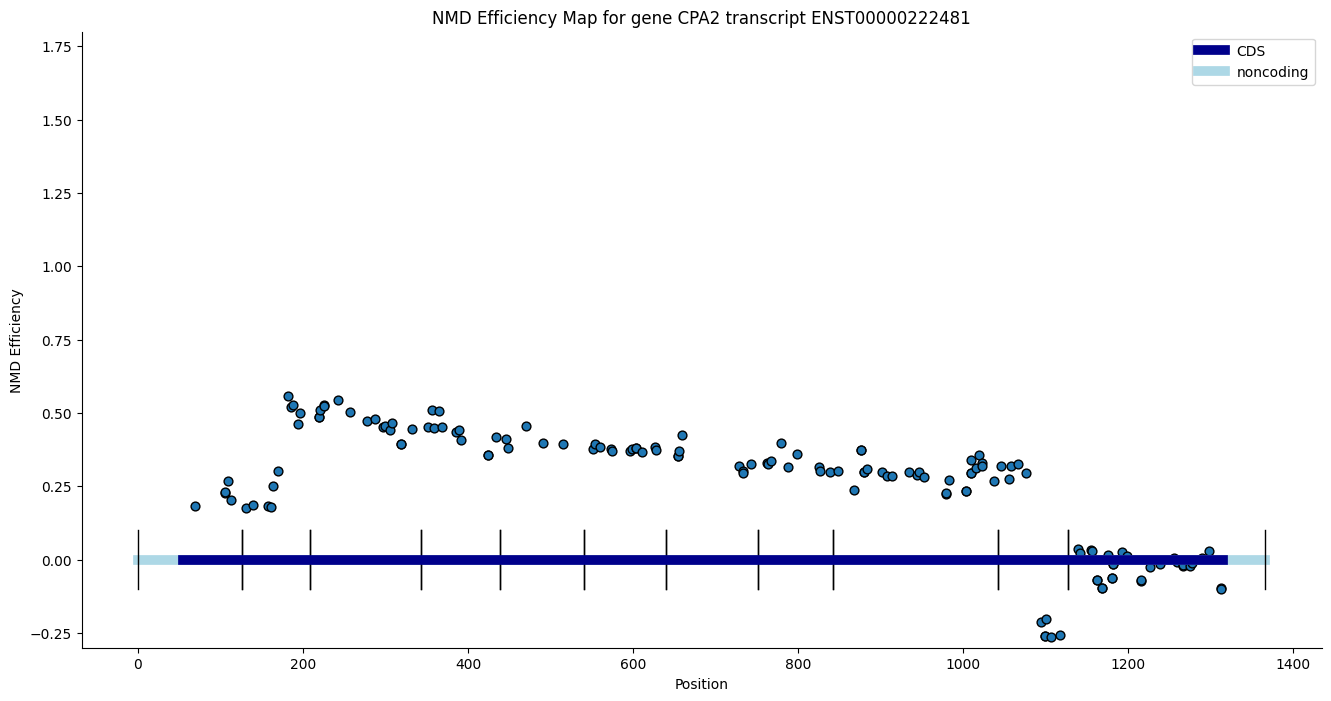

In [1281]:
# Compute exon widths for visualization (exons are continuous)
exon_widths = [exon["end_exon"] - exon["start_exon"] for exon in exons]

# Handle reverse strand
reverse_strand = t.strand == "-"
if reverse_strand:
    exons = exons[::-1]  # Reverse exon order
    exon_widths = exon_widths[::-1]  # Reverse exon widths

# Create a compressed coordinate system (continuous)
x_positions = [0]  # Start position for plotting
for width in exon_widths:
    x_positions.append(x_positions[-1] + width)

# Mock data for NMD efficiency: Replace with real data
df_nmd = pd.DataFrame({
    "nucleotide_position": NMD_in_selected_genes.POS.values.tolist(),  # Genomic positions
    "nmd_value": NMD_in_selected_genes.NMD_efficiency.values.tolist()  # NMD efficiency values
})

# Map genomic positions to compressed exon positions
compressed_nmd_positions = []
compressed_nmd_values = []

for index, row in df_nmd.iterrows():
    genomic_pos = row["nucleotide_position"]
    for i, exon in enumerate(exons):
        if exon["start_exon"] <= genomic_pos <= exon["end_exon"]:
            # Convert genomic position to compressed exon position
            if reverse_strand:
                compressed_pos = x_positions[-(i+2)] + (exon["end_exon"] - genomic_pos)  # Adjust for reverse order
            else:
                compressed_pos = x_positions[i] + (genomic_pos - exon["start_exon"])

            compressed_nmd_positions.append(compressed_pos)
            compressed_nmd_values.append(row["nmd_value"])
            break  # Stop searching once position is mapped

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Define colors
exon_color = "lightblue"
cds_color = "darkblue"

# Determine the global CDS start and end across all exons
cds_global_start = min(exon["start_cds"] for exon in exons if exon["start_cds"] is not None)
cds_global_end = max(exon["end_cds"] for exon in exons if exon["end_cds"] is not None)

# Convert global CDS start/end to compressed coordinates
cds_compressed_start = None
cds_compressed_end = None

# Plot exons and determine CDS region
for i in range(len(exons)):
    exon_start = x_positions[i]
    exon_end = x_positions[i+1]

    # Plot the full exon as a light blue bar (default non-CDS region)
    ax.plot([exon_start, exon_end], [0, 0], color=exon_color, linewidth=7)

    # Check if this exon contributes to the continuous CDS
    if exons[i]["end_exon"] >= cds_global_start and exons[i]["start_exon"] <= cds_global_end:
        # Determine where the CDS starts and ends in this exon
        cds_start = max(exons[i]["start_exon"], cds_global_start)
        cds_end = min(exons[i]["end_exon"], cds_global_end)

        # Convert to compressed positions
        compressed_cds_start = exon_start + (cds_start - exons[i]["start_exon"])
        compressed_cds_end = exon_start + (cds_end - exons[i]["start_exon"])

        # Track global CDS start and end
        if cds_compressed_start is None or compressed_cds_start < cds_compressed_start:
            cds_compressed_start = compressed_cds_start
        if cds_compressed_end is None or compressed_cds_end > cds_compressed_end:
            cds_compressed_end = compressed_cds_end

    # Add smaller vertical boundary lines for exons
    ax.plot([exon_start, exon_start], [-0.1, 0.1], color="black", linewidth=1)  # Left boundary
    ax.plot([exon_end, exon_end], [-0.1, 0.1], color="black", linewidth=1)  # Right boundary

# Plot the CDS as a **single continuous region**
if cds_compressed_start is not None and cds_compressed_end is not None:
    ax.plot([cds_compressed_start, cds_compressed_end], [0, 0], color=cds_color, linewidth=7)

# Overlay NMD efficiency as a dot plot
scatter = ax.scatter(compressed_nmd_positions, compressed_nmd_values, 
                     edgecolors="black", s=40, vmin=-1, vmax=1, marker="o")

# Formatting
ax.set_title(f"NMD Efficiency Map for gene {symbol} transcript {transcript_id}")
ax.set_xlabel("Position")
ax.set_ylabel("NMD Efficiency")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add color legend manually for CDS and non-CDS regions
legend_elements = [
    Line2D([0], [0], color=cds_color, linewidth=7, label="CDS"),
    Line2D([0], [0], color=exon_color, linewidth=7, label="noncoding")
]
ax.legend(handles=legend_elements, loc="upper right")
plt.ylim(-0.3, 1.8)

# Show the plot
plt.savefig(f"../res/plots/application_example/{selected_gene}_NMD.png", dpi=300, bbox_inches='tight')  
plt.show()

